# McDonald's Reviews Mood Modeling

This notebook demonstrates the complete workflow for mood modeling on McDonald's reviews using the `McdonaldsReviewsMoodModeling` class.

The class provides a clean, cached interface for:
- Loading semantic attributes
- Computing embeddings for training data
- Training multiple model types
- Analyzing model performance
- Managing all intermediate results

## Setup

In [7]:
# TODO: Implement defaults for paths
# Data folder containing the raw data and misc
datadir = '/Users/thorwhalen/Dropbox/py/proj/c/cosmodata/misc/mcdonalds_reviews'
# Project folder for storing embeddings and results
project_folder = '/Users/thorwhalen/Dropbox/_odata/figiri/mcdonalds_reviews/'
# Where the training data for semantic attributes is stored
semantic_attributes_dataset_dir='/Users/thorwhalen/.config/mood/semantic_attributes/'

In [1]:
import os
import pandas as pd
from config2py import process_path

In [3]:
# Setup data directory

datadir = process_path(datadir, ensure_dir_exists=True)
djoin = lambda *paths: os.path.join(datadir, *paths)
print(f"Working directory: {datadir}")

Working directory: /Users/thorwhalen/Dropbox/py/proj/c/cosmodata/misc/mcdonalds_reviews


## Initialize Data Accessor

The `McdonaldsReviewsMoodModeling` class extends the base `McdonaldsReviewsDacc` with mood modeling capabilities.
All expensive operations are automatically cached.

In [5]:
from imbed_data_prep.mcdonalds_reviews import McdonaldsReviewsMoodModeling

In [8]:
dacc = McdonaldsReviewsMoodModeling(
    datadir=datadir,
    semantic_attributes_path='semantic_attributes.json',
    semantic_attributes_dataset_dir='/Users/thorwhalen/.config/mood/semantic_attributes/',
    embeddings_folder=os.path.join(project_folder, 'embeddings'),
    results_folder=os.path.join(project_folder, 'mood_modeling_results'),
    cv_splits=30,
    verbose=1
)

## Load Base Review Data

First, let's verify we can access the basic McDonald's reviews data.

In [9]:
# Load raw data
df = dacc.raw_data
print(f"Loaded {len(df)} reviews")
df.head()

Loading raw data from /Users/thorwhalen/Dropbox/py/proj/c/cosmodata/misc/mcdonalds_reviews/McDonalds_Reviews_Cleaned.csv
Loaded 33396 reviews


,reviewer_id,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2023-04-01 00:00:00,Why does it look like someone spit on my food?...,1
1,2,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2023-06-25 00:00:00,It'd McDonalds. It is what it is as far as the...,4
2,3,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2023-06-25 00:00:00,Made a mobile order got to the speaker and che...,1
3,4,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2023-05-31 00:00:00,My mc. Crispy chicken sandwich was ___________...,5
4,5,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240,2023-05-01 00:00:00,"I repeat my order 3 times in the drive thru, a...",1


In [10]:
# Check data quality
print(f"Columns: {list(df.columns)}")
print(f"\nData shape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Columns: ['reviewer_id', 'store_address', 'latitude', 'longitude', 'rating_count', 'review_time', 'review', 'rating']

Data shape: (33396, 8)

Missing values:
reviewer_id        0
store_address      0
latitude         660
longitude        660
rating_count       0
review_time      125
review             0
rating             0
dtype: int64


## Semantic Attributes

Semantic attributes define the mood categories we're modeling.

In [11]:
# Load semantic attributes
semantic_attributes = dacc.semantic_attributes
print(f"Number of semantic attributes: {len(semantic_attributes)}")
print(f"\nCategories: {list(semantic_attributes.keys())}")

Loading semantic attributes from /Users/thorwhalen/Dropbox/py/proj/c/cosmodata/misc/mcdonalds_reviews/semantic_attributes.json
Number of semantic attributes: 9

Categories: ['food_quality_presentation', 'staff_behavior_attitude', 'order_accuracy_handling', 'speed_service', 'mobile_app_experience', 'cleanliness_hygiene', 'value_money', 'atmosphere_environment', 'trust_safety']


In [14]:
import textwrap
import dol 

print_wrapped = lambda text: print(textwrap.fill(text, width=80))

# Display all semantic attributes with descriptions
for category, description in semantic_attributes.items():
    print(f"\n{'='*80}")
    print(f"{category}")
    print(f"{'='*80}")
    print_wrapped(description)


food_quality_presentation
Food Quality & Presentation (Perception of the taste, freshness, temperature,
and presentation of food. Example: 'Chicken sandwich was burnt.' Keywords: cold,
burnt, delicious, disgusting, fresh, presentation, undercooked, soggy, raw)

staff_behavior_attitude
Staff Behavior & Attitude (Describes staff friendliness, professionalism, or
rudeness. Example: 'They are all friendly, accommodating and always smiling.'
Keywords: rude, friendly, polite, helpful, attitude, respectful, smiling,
manager, hostile)

order_accuracy_handling
Order Accuracy & Handling (Concerns about wrong, missing, or mishandled orders.
Example: 'After getting home, I had no regular hamburg but had cookies.'
Keywords: wrong order, missing, forgot, custom order, receipt, error, incorrect,
mix-up)

speed_service
Speed of Service / Wait Time (Comments on timeliness, including delays or quick
service. Example: 'Line was not moving so I had to leave otherwise be late for
work.' Keywords: long lin

## Dataset Statistics

Let's see how many training examples we have for each category.

In [15]:
# Get dataset statistics
stats = dacc.dataset_statistics()
stats

,semantic_attribute,number_of_examples
0,atmosphere_environment,690
1,order_accuracy_handling,915
2,cleanliness_hygiene,750
3,food_quality_presentation,814
4,staff_behavior_attitude,846
5,value_money,760
6,mobile_app_experience,696
7,speed_service,799
8,trust_safety,867


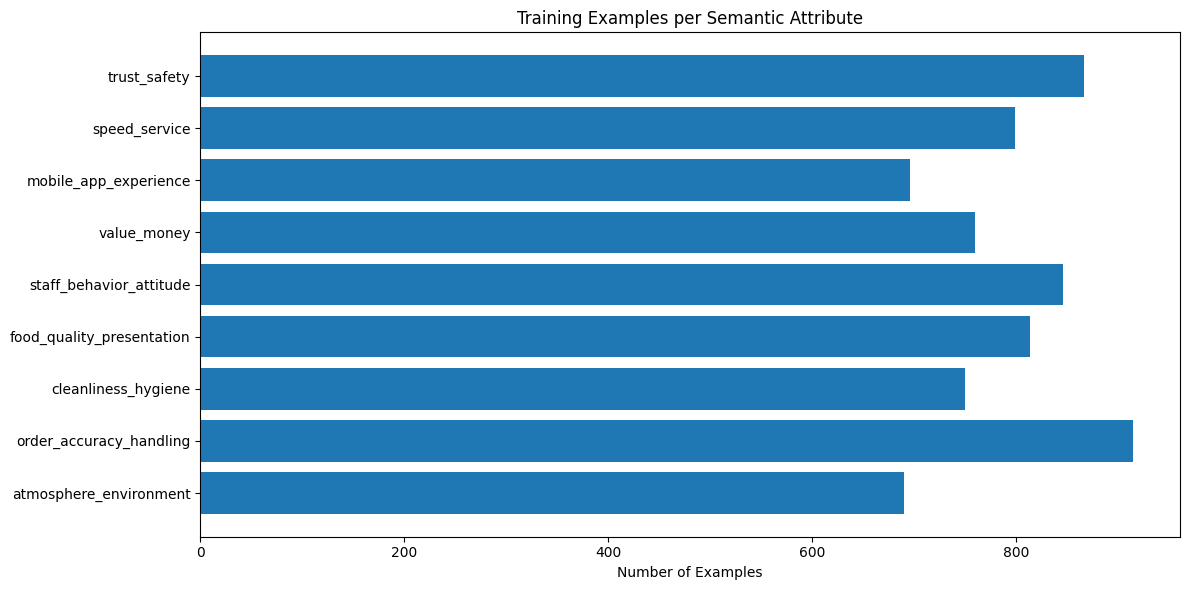

In [16]:
# Visualize distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(stats['semantic_attribute'], stats['number_of_examples'])
plt.xlabel('Number of Examples')
plt.title('Training Examples per Semantic Attribute')
plt.tight_layout()
plt.show()

## Explore a Single Category

Let's examine one category in detail before processing all of them.

In [17]:
# Choose a category to explore
example_category = 'food_quality_presentation'
print(f"Exploring category: {example_category}")

Exploring category: food_quality_presentation


In [18]:
# Get segments and scores
segments, scores = dacc.category_segments(example_category)

print(f"Number of segments: {len(segments)}")
print(f"\nScore distribution:")
print(scores.value_counts().sort_index())

Number of segments: 814

Score distribution:
score
0    129
1    137
2    139
3    139
4    138
5    132
Name: count, dtype: int64


In [19]:
# Show some example segments
print("Example segments:")
for i in range(min(5, len(segments))):
    print(f"\n[Score: {scores.iloc[i]}] {segments.iloc[i]}")

Example segments:

[Score: 0] Chicken tasted like cardboard and was cold.

[Score: 1] The pasta was a bit undercooked and bland.

[Score: 2] The salad was okay, nothing special.

[Score: 3] The burger was decent, but the fries were soggy.

[Score: 4] The steak was perfectly cooked, juicy, and flavorful.


## Compute Embeddings

Embeddings are computed using OpenAI's API and cached automatically.

In [20]:
# Compute embeddings for the example category
# Note: This will be cached, so subsequent calls are instant
embeddings = dacc.category_embeddings(example_category)
print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimension: {len(embeddings['embedding'].iloc[0])}")
embeddings.head()

Computing embeddings for food_quality_presentation (814 segments)


In [ ]:
# Get X, y arrays ready for modeling
X, y = dacc.category_xy(example_category)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nLabel distribution in y: {pd.Series(y).value_counts().sort_index()}")

## Compute Embeddings for All Categories

Now let's process all categories. This may take time on first run, but results are cached.

In [ ]:
# Get list of all categories
categories = dacc.list_categories()
print(f"Total categories: {len(categories)}")
print(f"Categories: {categories}")

In [ ]:
# Compute embeddings for all categories
# This will take some time on first run (~23 seconds per category based on your notes)
print("Computing embeddings for all categories...\n")

for i, category in enumerate(categories, 1):
    print(f"[{i}/{len(categories)}] {category}")
    embeddings = dacc.category_embeddings(category)
    print(f"  ✓ Shape: {embeddings.shape}")

print("\n✓ All embeddings computed and cached!")

## Train Models for a Single Category

Let's train all model types for one category first to see the results.

In [ ]:
# Train models for the example category
print(f"Training models for: {example_category}\n")
results = dacc.category_results(example_category)

print(f"Available result keys: {list(results.keys())}")
print(f"\nModel types trained: {list(results['results'].keys())}")

In [ ]:
# Display model summary
summary = dacc.category_model_summary(example_category)
summary

In [ ]:
# Visualize model performance
import matplotlib.pyplot as plt

# Assuming summary has an 'accuracy' or similar metric column
if 'mean_accuracy' in summary.columns:
    plt.figure(figsize=(10, 6))
    summary_sorted = summary.sort_values('mean_accuracy', ascending=True)
    plt.barh(summary_sorted.index, summary_sorted['mean_accuracy'])
    plt.xlabel('Accuracy')
    plt.title(f'Model Performance: {example_category}')
    plt.tight_layout()
    plt.show()

## Train Models for All Categories

Now let's train models for all categories. Results are cached, so this only takes time on first run.

In [ ]:
# Train all models for all categories
# This is the equivalent of your run_experiments() function
print(f"Training models for {len(categories)} categories...\n")

all_results = dacc.all_category_results()

print("\n✓ All models trained and cached!")

## Analyze Results Across All Categories

In [ ]:
# Create a summary table across all categories
summary_data = []

for category in categories:
    summary = dacc.category_model_summary(category)
    # Get best performing model
    if 'mean_accuracy' in summary.columns:
        best_model = summary['mean_accuracy'].idxmax()
        best_accuracy = summary.loc[best_model, 'mean_accuracy']
        summary_data.append({
            'category': category,
            'best_model': best_model,
            'best_accuracy': best_accuracy
        })

overall_summary = pd.DataFrame(summary_data)
overall_summary.sort_values('best_accuracy', ascending=False)

In [ ]:
# Visualize best model performance across categories
plt.figure(figsize=(12, 8))
plt.barh(overall_summary['category'], overall_summary['best_accuracy'])
plt.xlabel('Best Model Accuracy')
plt.title('Best Model Performance per Semantic Attribute')
plt.tight_layout()
plt.show()

## Deep Dive: Specific Category Analysis

Let's do a detailed analysis of a specific category.

In [ ]:
# Choose category for deep dive
target_category = 'order_accuracy_handling'
print(f"Deep dive on: {target_category}")

In [ ]:
# Get full results
results = dacc.category_results(target_category)

print("Available information:")
print(f"  - Single train/test split results: {list(results['results'].keys())}")
print(f"  - Cross-validation results available: {'cv_results' in results}")
print(f"  - Summary table available: {'summary' in results}")

In [ ]:
# Display detailed summary
summary = dacc.category_model_summary(target_category)
summary

In [ ]:
# Get configuration for a specific model
model_name = 'logistic_high_vs_low'
config = dacc.category_model_config(target_category, model_name)

print(f"Configuration for {model_name}:")
print(f"  Model class: {config['model_class']}")
print(f"  Model parameters: {config['model_params']}")

## Train and Use a Specific Model

Let's train a specific model and use it for predictions.

In [ ]:
# Train a specific model
model = dacc.train_model(target_category, model_name)
print(f"Trained {model_name} for {target_category}")
print(f"Model type: {type(model)}")

In [ ]:
# Get test data
X, y = dacc.category_xy(target_category)
print(f"Data shape: X={X.shape}, y={y.shape}")

In [ ]:
# Make predictions on sample data
n_samples = 10
predictions = model.predict(X[:n_samples])
actuals = y[:n_samples]

print("Sample predictions:")
comparison_df = pd.DataFrame({
    'Predicted': predictions,
    'Actual': actuals,
    'Correct': predictions == actuals
}, index=range(n_samples))
comparison_df

In [ ]:
# Show corresponding segments
segments, scores = dacc.category_segments(target_category)

print("\nSegments with predictions:")
for i in range(n_samples):
    print(f"\n[{i}] Predicted: {predictions[i]}, Actual: {actuals[i]}")
    print(f"    {segments.iloc[i][:100]}...")

## Model Comparison Across Categories

Compare how different model types perform across all categories.

In [ ]:
# Get all model types (assuming they're the same across categories)
first_category = categories[0]
first_results = dacc.category_results(first_category)
model_types = list(first_results['results'].keys())

print(f"Model types to compare: {model_types}")

In [ ]:
# Create comparison dataframe
comparison_data = []

for category in categories:
    summary = dacc.category_model_summary(category)
    for model_type in model_types:
        if model_type in summary.index and 'mean_accuracy' in summary.columns:
            comparison_data.append({
                'category': category,
                'model': model_type,
                'accuracy': summary.loc[model_type, 'mean_accuracy']
            })

comparison_df = pd.DataFrame(comparison_data)
comparison_pivot = comparison_df.pivot(index='category', columns='model', values='accuracy')
comparison_pivot

In [ ]:
# Visualize model comparison
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(comparison_pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5)
plt.title('Model Performance Comparison Across Categories')
plt.xlabel('Model Type')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

## Cache Management

The `McdonaldsReviewsMoodModeling` class automatically caches all expensive operations. Here's how to manage the cache.

In [ ]:
# Check what's cached for embeddings
print("Cached embeddings:")
print(list(dacc._embeddings_store))

In [ ]:
# Check what's cached for results
print("Cached results:")
print(list(dacc._results_store))

In [ ]:
# Clear cache for a specific category (if needed)
# Uncomment to actually clear:
# dacc.clear_category_cache('food_quality_presentation')
# print("Cache cleared for food_quality_presentation")

## Export Results

Export key results for further analysis or reporting.

In [ ]:
# Export overall summary
output_dir = os.path.join(project_folder, 'analysis_outputs')
os.makedirs(output_dir, exist_ok=True)

overall_summary.to_csv(os.path.join(output_dir, 'best_models_summary.csv'), index=False)
comparison_pivot.to_csv(os.path.join(output_dir, 'model_comparison.csv'))

print(f"Results exported to {output_dir}")

In [ ]:
# Export detailed results for each category
for category in categories:
    summary = dacc.category_model_summary(category)
    filename = f"{category}_summary.csv"
    summary.to_csv(os.path.join(output_dir, filename))

print(f"Exported summaries for all {len(categories)} categories")

## Summary

This notebook demonstrated the complete mood modeling workflow using `McdonaldsReviewsMoodModeling`:

1. ✓ Loaded semantic attributes
2. ✓ Computed embeddings for all categories (cached)
3. ✓ Trained multiple model types for all categories (cached)
4. ✓ Analyzed model performance
5. ✓ Compared models across categories
6. ✓ Exported results

### Key Benefits of Using McdonaldsReviewsMoodModeling:

- **Automatic caching**: All expensive operations are cached automatically
- **Clean API**: Simple, intuitive methods replace complex store management
- **Persistent storage**: Results persist across sessions
- **Reproducible**: Run the notebook multiple times without recomputing
- **Modular**: Easy to extend with new methods or analyses

In [ ]:
# Final summary statistics
print("="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nCategories processed: {len(categories)}")
print(f"Total training examples: {stats['number_of_examples'].sum()}")
print(f"Model types trained per category: {len(model_types)}")
print(f"\nBest overall category (by accuracy): {overall_summary.iloc[0]['category']}")
print(f"Best overall accuracy: {overall_summary.iloc[0]['best_accuracy']:.3f}")
print(f"\nAll results cached in:")
print(f"  - Embeddings: {dacc.embeddings_folder}")
print(f"  - Results: {dacc.results_folder}")

In [3]:
from i2 import Sig
from operator import itemgetter

Sig(itemgetter)

<Sig (key: ~KT, /, *keys: Iterable[~KT]) -> Callable[[Iterable[~VT]], Union[~VT, Tuple[~VT]]]>